In [5]:
import pandas as pd

# Replace 'your_file.tsv' with the path to your actual file
file_path = 'resources/data_augmentation/users_one_of.tsv'

# Read the TSV file
df = pd.read_csv(file_path, sep='\t', header=0)

df.columns = df.columns.str.strip()

# Display the first few rows to check if it loaded correctly
print(df.head())

   revision_id property_id                                      result_string  \
0    301384944       P1046  https://www.wikidata.org/w/index.php?title=Pro...   
1    301384994       P1046  https://www.wikidata.org/w/index.php?title=Pro...   
2    301385066       P1046  https://www.wikidata.org/w/index.php?title=Pro...   
3    301385364       P1046  https://www.wikidata.org/w/index.php?title=Pro...   
4    301385415       P1046  https://www.wikidata.org/w/index.php?title=Pro...   

                              Full_User_URL  \
0  https://www.wikidata.org/wiki/User:Mu301   
1  https://www.wikidata.org/wiki/User:Mu301   
2  https://www.wikidata.org/wiki/User:Mu301   
3  https://www.wikidata.org/wiki/User:Mu301   
4  https://www.wikidata.org/wiki/User:Mu301   

                                constraint.statement  \
0  <http://www.wikidata.org/entity/statement/P104...   
1  <http://www.wikidata.org/entity/statement/P104...   
2  <http://www.wikidata.org/entity/statement/P104...   
3  <ht

In [6]:
len(df)

13709

In [7]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import classification_report

def extract_username(url):
    if pd.isnull(url):
        return None
    username = url.split('User:')[-1]
    # Check if it's an IP address
    if re.match(r'^\d{1,3}(\.\d{1,3}){3}$', username):
        return "Anonymous"
    return username

# 2. Extract username safely
df['username'] = df['Full_User_URL'].apply(extract_username)

Extract qid and pid

In [8]:
import re

def extract_qid(uri):
    match = re.search(r'Q\d+', uri)
    return match.group(0) if match else ''

def extract_pid(uri):
    match = re.search(r'P\d+', uri)
    return match.group(0) if match else ''

df_user_Qid_Pid = df[['username', 'subject.t0', 'predicate.t0']].copy()
# Extract QID and PID
df_user_Qid_Pid['qid'] = df_user_Qid_Pid['subject.t0'].apply(extract_qid)
df_user_Qid_Pid['pid'] = df_user_Qid_Pid['predicate.t0'].apply(extract_pid)
df_user_Qid_Pid = df_user_Qid_Pid.drop(['subject.t0', 'predicate.t0'], axis=1)

In [9]:
df_user_Qid_Pid.head()

,username,qid,pid
0,Mu301,Q246648,P1046
1,Mu301,Q1073944,P1046
2,Mu301,Q11394346,P1046
3,Mu301,Q18819063,P1046
4,Mu301,Q18921090,P1046


In [10]:
df_user_Qid_Pid.dtypes

username    object
qid         object
pid         object
dtype: object

## Goal: Identify power users vs. casual contributors.

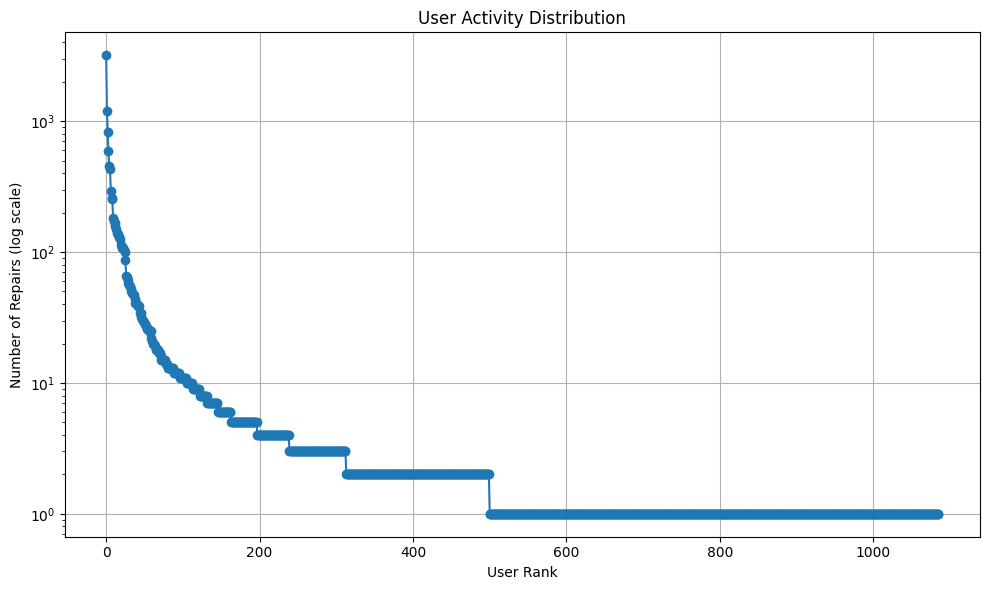

In [11]:
import matplotlib.pyplot as plt

# Count the number of questions per user
user_counts = df_user_Qid_Pid['username'].value_counts()

# Sort values from highest to lowest
sorted_counts = user_counts.sort_values(ascending=False).reset_index(drop=True)

# Plot a curve
plt.figure(figsize=(10, 6))
plt.plot(sorted_counts.values, marker='o', linestyle='-')
plt.yscale('log')  # Optional: use logarithmic scale for y-axis
plt.xlabel('User Rank')
plt.ylabel('Number of Repairs (log scale)')
plt.title('User Activity Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
!pip install -U sentence-transformers

## Reading abstracts file and generating embeddings

In [12]:
import pandas as pd
from sentence_transformers import SentenceTransformer

''' Step 1: Read Abstracts CSV
You can switch the source by uncommenting one of the lines below.'''

'''DBpedia (first 5 sentences from each abstract)'''
# abstracts_df = pd.read_csv('resources/data_augmentation/dbpedia_abstracts/oneOf_abstracts_first_5_sentences.csv')

'''Wikidata (generated text based on triples)'''
# abstracts_df = pd.read_csv('resources/data_augmentation/wikidata_texts/wikidata_texts_oneOf.csv')

'''Final version: includes both DBpedia abstracts and Wikidata-based generated texts'''
abstracts_df = pd.read_csv('resources/data_augmentation/final_entity_texts.csv')

# Normalize QID formatting just in case
abstracts_df['QID'] = abstracts_df['QID'].str.strip()
abstracts_df['abstract'] = abstracts_df['abstract'].fillna('').astype(str)

# Step 2: Filter df_user_Qid_Pid
qid_set_with_abstract = set(abstracts_df['QID'])
df_valid = df_user_Qid_Pid[df_user_Qid_Pid['qid'].isin(qid_set_with_abstract)].copy()
df_missing = df_user_Qid_Pid[~df_user_Qid_Pid['qid'].isin(qid_set_with_abstract)].copy() 

print(f"✅ Kept {len(df_valid)} rows with abstracts.")
print(f"⚠️  Moved {len(df_missing)} rows to df_missing for later handling.")

# Step 3: Generate Sentence Embeddings for Abstracts
model = SentenceTransformer('all-distilroberta-v1')

# Create dictionary: QID → embedding
abstracts = abstracts_df.set_index('QID')['abstract'].to_dict()
qid_list = list(abstracts.keys())
abstract_list = list(abstracts.values())

print("⚙️ Encoding abstracts using all-distilroberta-v1...")
embeddings = model.encode(abstract_list, show_progress_bar=True)

# Build QID → embedding dictionary
qid_to_embedding = {qid: emb for qid, emb in zip(qid_list, embeddings)}

✅ Kept 13248 rows with abstracts.
⚠️  Moved 461 rows to df_missing for later handling.
⚙️ Encoding abstracts using all-distilroberta-v1...


Batches:   0%|          | 0/374 [00:00<?, ?it/s]c:\Users\solan\OneDrive\Área de Trabalho\wd_user_recommendation\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 374/374 [28:30<00:00,  4.57s/it] 


## saving embeddings for further reuse:

In [ ]:
import pickle

with open('resources/semantic_mapping/qid_to_embedding_all.pkl', 'wb') as f:
    pickle.dump(qid_to_embedding, f)

In [13]:
len(qid_to_embedding['Q25907657'])

768

## Trying entity cluster

In [14]:
import numpy as np

qid_list = list(qid_to_embedding.keys())
embedding_matrix = np.stack([qid_to_embedding[qid] for qid in qid_list])

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)
embedding_pca = pca.fit_transform(embedding_matrix)


In [17]:
import numpy as np

qid_list = list(qid_to_embedding.keys())
embedding_matrix = np.stack([qid_to_embedding[qid] for qid in qid_list])

In [18]:
from sklearn.cluster import KMeans

n_clusters = 12  # Try different values later
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
qid_clusters = kmeans.fit_predict(embedding_pca)

In [19]:
import pandas as pd

qid_cluster_df = pd.DataFrame({
    'qid': qid_list,
    'cluster': qid_clusters
})

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Use the same PCA-reduced embeddings
silhouette = silhouette_score(embedding_pca, qid_clusters)
ch_score = calinski_harabasz_score(embedding_pca, qid_clusters)
db_score = davies_bouldin_score(embedding_pca, qid_clusters)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Index: {ch_score:.2f}")
print(f"Davies-Bouldin Index: {db_score:.3f}")


Silhouette Score: 0.076
Calinski-Harabasz Index: 387.48
Davies-Bouldin Index: 3.111


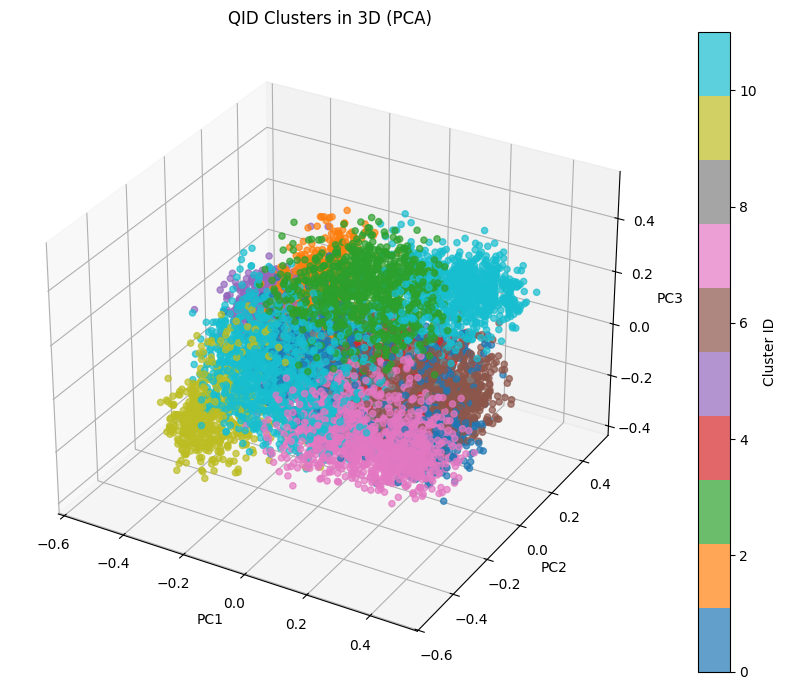

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3 components for 3D plot
pca_3d = PCA(n_components=3)
embedding_3d = pca_3d.fit_transform(embedding_matrix)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    embedding_3d[:, 0],
    embedding_3d[:, 1],
    embedding_3d[:, 2],
    c=qid_clusters,
    cmap='tab10',
    alpha=0.7
)

ax.set_title("QID Clusters in 3D (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()


In [ ]:
# Sample 5 QIDs per cluster
for i in range(12):
    sample_qids = qid_cluster_df[qid_cluster_df['cluster'] == i]['qid'].sample(5, random_state=42)
    print(f"\nCluster {i}:")
    for qid in sample_qids:
        print(f"- {qid}: {abstracts[qid][:120]}...")


Cluster 0:
- Q1840423: Mieke de Boer (born 11 January 1980 in Maastricht, Limburg) is a former darts player from the Netherlands, who was nickn...
- Q25907657: AD Rahmannshof's Bogeno is a male Belgian Sport Horse, born on January 1, 2000. This horse breed is known for its athlet...
- Q2833189: Miro, also known by his native name Miroslav, is a Bulgarian professional wrestler, rower, and powerlifter who currently...
- Q149557: Justin Raimondo (born Dennis Raimondo; November 18, 1951 – June 27, 2019) was an American author and the editorial direc...
- Q28064666: StanVik is a Nigerian singer who was born on September 30, 1994, in the bustling city of Lagos, Nigeria's largest city a...

Cluster 1:
- Q21396210: Sotirios Petimezas was a man born in the village of Kato Lousi, Achaea, Greece, on January 1, 1723. He was the son of An...
- Q103932: Georg von Detten was a German politician, born on September 9, 1887, in Hagen, Germany. He spoke and wrote in German, th...
- Q876674: John II, nic

In [ ]:
!pip install umap-learn hdbscan scikit-learn

## let's try different reducers (PCA or UMAP) and 4 different Clustering algos.

In [ ]:
import numpy as np
import pandas as pd
import umap
import hdbscan
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm

# ------------------------------
# Input: embedding_matrix (QID x 768)
# ------------------------------

# Configurations
cluster_counts = [5, 10, 15, 20]
reducers = {
    "PCA": PCA(n_components=50, random_state=42),
    "UMAP": umap.UMAP(n_components=50, random_state=42),
}
clustering_algos = {
    "KMeans": lambda k: KMeans(n_clusters=k, random_state=42),
    "GMM": lambda k: GaussianMixture(n_components=k, random_state=42),
    "Spectral": lambda k: SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors'),
    "HDBSCAN": lambda _: hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
}

results = []

print("🚀 Starting clustering experiment...")

# Loop through reduction methods
for reducer_name, reducer in reducers.items():
    print(f"\n🔄 Reducing dimensions with {reducer_name}...")
    X_reduced = reducer.fit_transform(embedding_matrix)

    for algo_name, algo_fn in clustering_algos.items():
        if algo_name == "HDBSCAN":
            print(f"🤖 Clustering with HDBSCAN (no fixed k)...")
            labels = algo_fn(None).fit_predict(X_reduced)
            # Skip noisy clusters (-1)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            if n_clusters < 2:
                continue
            valid_idx = labels != -1
            try:
                sil = silhouette_score(X_reduced[valid_idx], labels[valid_idx])
                ch = calinski_harabasz_score(X_reduced[valid_idx], labels[valid_idx])
                db = davies_bouldin_score(X_reduced[valid_idx], labels[valid_idx])
                results.append({
                    "Reducer": reducer_name,
                    "Clustering": algo_name,
                    "Clusters": n_clusters,
                    "Silhouette": sil,
                    "Calinski-Harabasz": ch,
                    "Davies-Bouldin": db
                })
            except:
                print(f"⚠️  Skipped due to insufficient cluster separation.")
            continue

        for k in cluster_counts:
            print(f"🤖 Clustering with {algo_name} (k={k})...")
            try:
                model = algo_fn(k)
                if algo_name == "GMM":
                    labels = model.fit_predict(X_reduced)
                else:
                    labels = model.fit(X_reduced).labels_

                sil = silhouette_score(X_reduced, labels)
                ch = calinski_harabasz_score(X_reduced, labels)
                db = davies_bouldin_score(X_reduced, labels)

                results.append({
                    "Reducer": reducer_name,
                    "Clustering": algo_name,
                    "Clusters": k,
                    "Silhouette": sil,
                    "Calinski-Harabasz": ch,
                    "Davies-Bouldin": db
                })
            except Exception as e:
                print(f"❌ Failed: {algo_name} with {k} clusters — {e}")

# Create results DataFrame and rank
df_results = pd.DataFrame(results)
df_results["Rank"] = df_results["Silhouette"].rank(ascending=False)

# Display top-ranked methods
df_results.sort_values("Silhouette", ascending=False, inplace=True)
print("\n✅ Top clustering configurations by Silhouette score:")
import ace_tools as tools; tools.display_dataframe_to_user(name="Clustering Benchmark Results", dataframe=df_results)

# Optional: Save
# df_results.to_csv("clustering_benchmark_results.csv", index=False)

In [ ]:
import pandas as pd

# Adjust display options
pd.set_option('display.width', None)           # Let pandas auto-detect best width
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.max_colwidth', None)    # Show full column contents (use 'None' in pandas >=1.0)


print(df_results.sort_values("Silhouette", ascending=False).head(10))

# Silhouette Score (-1 to 1, higher is better)
# Calinski-Harabasz Index (higher is better)
# Davies-Bouldin Index (lower is better)

   Reducer Clustering  Clusters  Silhouette  Calinski-Harabasz  \
25    UMAP    HDBSCAN       125    0.546150        4832.111328   
15    UMAP     KMeans        15    0.454985       11671.313477   
19    UMAP        GMM        15    0.446530       11144.990234   
16    UMAP     KMeans        20    0.433096       11941.071289   
14    UMAP     KMeans        10    0.432464        8772.698242   
18    UMAP        GMM        10    0.413989        8240.430664   
20    UMAP        GMM        20    0.413847       11274.793945   
13    UMAP     KMeans         5    0.374506        7285.303711   
17    UMAP        GMM         5    0.331176        6351.092285   
12     PCA    HDBSCAN        22    0.241348         128.897385   

    Davies-Bouldin  Rank  
25        0.488366   1.0  
15        0.762777   2.0  
19        0.784369   3.0  
16        0.870443   4.0  
14        0.785787   5.0  
18        0.839421   6.0  
20        0.895154   7.0  
13        0.907119   8.0  
17        1.099471   9.0  
12 

🔄 Reducing to 50D with UMAP...


/home/guimaraes/Desktop/wikidata_text_generate/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🔍 Clustering with HDBSCAN...
🧭 Reducing to 3D for visualization...


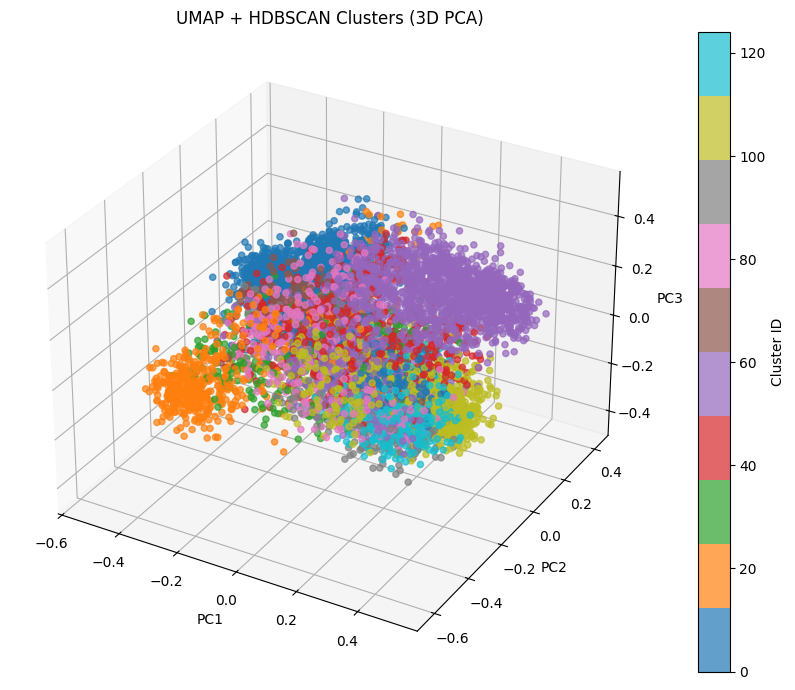


📌 Top 5 entities per cluster:


🧩 Cluster 0 (top 5 entities):
- Q23034741: The first Monday in February, also known as the initial occurrence of Monday in the second month of the Julian and Gregorian calendars, is a specific ...
- Q14916525: The first Monday in May, also known as the first occurrence of Monday in the month of May, is a specific date within the Gregorian and Julian calendar...
- Q23034743: The first Monday in March, also known as the initial occurrence of Monday in the third month of the Julian and Gregorian calendars, is a specific day ...
- Q14916785: The first Monday in November is a specific date that falls within the eleventh month of the Julian and Gregorian calendars. This day is significant as...
- Q14914714: The first Monday in August is a specific date that occurs annually during the eighth month of the Julian and Gregorian calendar systems. This day is s...

🧩 Cluster 1 (top 5 entities):
- Q4847546: †Helenoconcha leptalea is an extinct species of small air-b

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D
import hdbscan
import umap

# ----------- 1. Run UMAP + HDBSCAN if not done ------------
print("🔄 Reducing to 50D with UMAP...")
umap_model = umap.UMAP(n_components=50, random_state=42)
X_umap = umap_model.fit_transform(embedding_matrix)

print("🔍 Clustering with HDBSCAN...")
hdb = hdbscan.HDBSCAN(min_cluster_size=10, prediction_data=True)
labels = hdb.fit_predict(X_umap)

# Filter noise
valid_mask = labels != -1
valid_embeddings = embedding_matrix[valid_mask]
valid_labels = labels[valid_mask]
valid_qids = np.array(qid_list)[valid_mask]

# ----------- 2. Visualize in 3D ------------
print("🧭 Reducing to 3D for visualization...")
pca_3d = PCA(n_components=3)
X_3d = pca_3d.fit_transform(valid_embeddings)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=valid_labels, cmap='tab10', alpha=0.7)
ax.set_title("UMAP + HDBSCAN Clusters (3D PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.colorbar(scatter, label="Cluster ID")
plt.tight_layout()
plt.show()

# ----------- 3. Top 5 closest QIDs to each centroid ------------
print("\n📌 Top 5 entities per cluster:\n")

unique_labels = np.unique(valid_labels)
for cluster_id in unique_labels:
    indices = np.where(valid_labels == cluster_id)[0]
    cluster_embeddings = valid_embeddings[indices]

    # Compute centroid
    centroid = np.mean(cluster_embeddings, axis=0)

    # Distances from centroid
    distances = euclidean_distances(cluster_embeddings, centroid.reshape(1, -1)).flatten()
    top_indices = distances.argsort()[:5]

    print(f"\n🧩 Cluster {cluster_id} (top 5 entities):")
    for idx in top_indices:
        qid = valid_qids[indices[idx]]
        snippet = abstracts[qid][:150].replace("\n", " ")
        print(f"- {qid}: {snippet}...")



In [ ]:
df_clustered

let’s now map QIDs to users, and then determine how many distinct users have edited entities in each of the 68 UMAP + HDBSCAN clusters.

In [ ]:
# Step 1: QID → Cluster ID mapping
qid_cluster_map = dict(zip(valid_qids, valid_labels))

# Step 2: Map QID clusters onto df_valid
df_valid['qid_cluster'] = df_valid['qid'].map(qid_cluster_map)

# Step 3: Drop rows where cluster is NaN (QIDs not clustered)
df_clustered = df_valid.dropna(subset=['qid_cluster']).copy()
df_clustered['qid_cluster'] = df_clustered['qid_cluster'].astype(int)

# Step 4: Count distinct users per cluster
user_counts = df_clustered.groupby('qid_cluster')['username'].nunique().reset_index()
user_counts.columns = ['cluster_id', 'distinct_user_count']

# Optional: Sort descending
user_counts_sorted = user_counts.sort_values(by='distinct_user_count', ascending=False)

# Show summary
print("\n📊 Distinct users per UMAP + HDBSCAN cluster (top 10):")
print(user_counts_sorted.to_string())

# Optional: Save or visualize
# user_counts_sorted.to_csv("user_counts_per_cluster.csv", index=False)


📊 Distinct users per UMAP + HDBSCAN cluster (top 10):
     cluster_id  distinct_user_count
52           52                  222
5             5                   83
45           45                   78
38           38                   72
109         109                   71
73           73                   60
12           12                   59
6             6                   48
59           59                   44
16           16                   44
81           81                   42
69           69                   42
96           96                   40
120         120                   39
1             1                   37
47           47                   35
39           39                   34
100         100                   33
97           97                   30
17           17                   30
87           87                   29
106         106                   26
85           85                   24
23           23                   22
46           46     

In [ ]:
total_distinct_users = df_clustered['username'].nunique()
print(f"👥 Total distinct users in clustered QIDs: {total_distinct_users}")

👥 Total distinct users in clustered QIDs: 770


/tmp/ipykernel_1699399/2351798931.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/guimaraes/Desktop/wikidata_text_generate/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


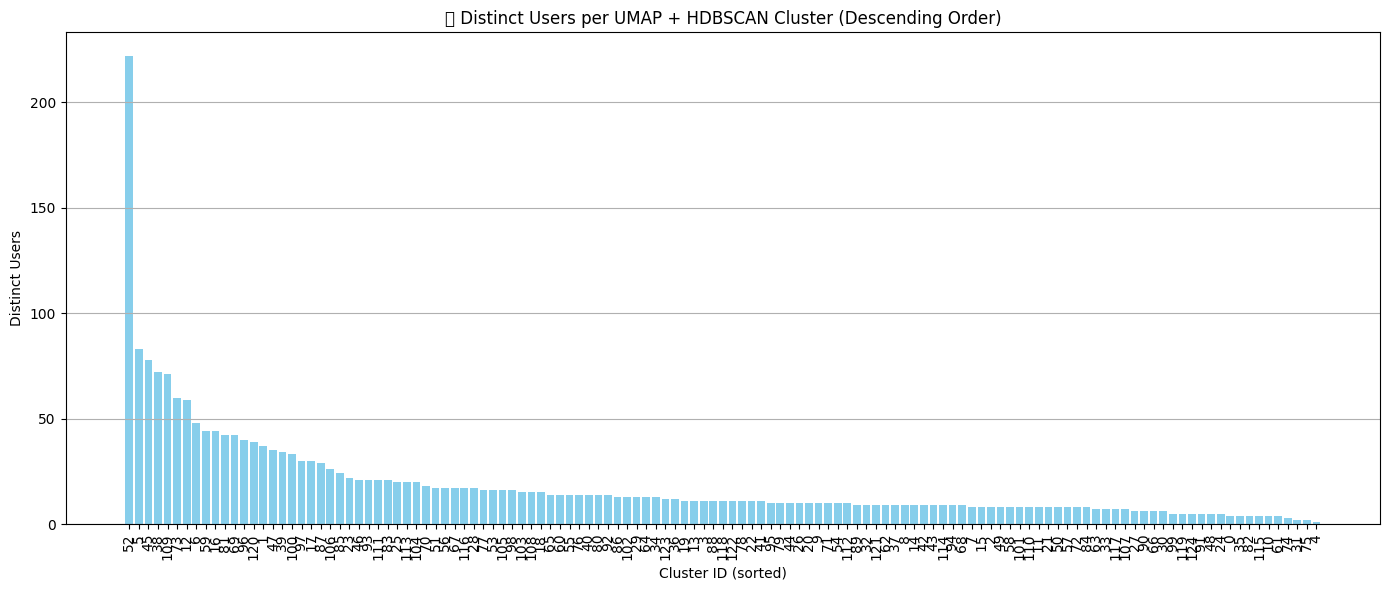

In [ ]:
import matplotlib.pyplot as plt

# Ensure user_counts_sorted exists (from earlier)
# user_counts_sorted = df_clustered.groupby('qid_cluster')['username'].nunique().reset_index()
# user_counts_sorted.columns = ['cluster_id', 'distinct_user_count']
# user_counts_sorted = user_counts_sorted.sort_values(by='distinct_user_count', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(user_counts_sorted['cluster_id'].astype(str), user_counts_sorted['distinct_user_count'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel("Cluster ID (sorted)")
plt.ylabel("Distinct Users")
plt.title("📊 Distinct Users per UMAP + HDBSCAN Cluster (Descending Order)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# --- Step 1: Map QID to cluster ID ---
qid_cluster_map = dict(zip(valid_qids, valid_labels))
df_valid['qid_cluster'] = df_valid['qid'].map(qid_cluster_map)

# --- Step 2: Filter valid clustered QIDs ---
df_clustered = df_valid.dropna(subset=['qid_cluster']).copy()
df_clustered['qid_cluster'] = df_clustered['qid_cluster'].astype(int)

# --- Step 3: Count how many different clusters each user appears in ---
user_to_num_clusters = df_clustered.groupby('username')['qid_cluster'].nunique()

# --- Step 4: Create a distribution and rename properly ---
cluster_count_distribution = user_to_num_clusters.value_counts().sort_index()
cluster_count_distribution.index.name = 'number_of_clusters'
cluster_count_distribution.name = 'user_count'

# --- Step 5: Print clean summary ---
print("\n📈 Distribution: How many clusters each user appears in:")
print(cluster_count_distribution)

total_users = cluster_count_distribution.sum()
users_in_1_cluster = cluster_count_distribution.get(1, 0)
users_in_multiple_clusters = total_users - users_in_1_cluster

print(f"\nTotal users: {total_users}")
print(f"Users in ONLY 1 cluster: {users_in_1_cluster} ({users_in_1_cluster / total_users:.2%})")
print(f"Users in MORE THAN 1 cluster: {users_in_multiple_clusters} ({users_in_multiple_clusters / total_users:.2%})")

# --- Step 6: Plot ---
plt.figure(figsize=(8, 5))
cluster_count_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Number of Clusters per User')
plt.xlabel('Number of Clusters')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# let's find some keywords to describe each cluster:

In [ ]:
!pip install keybert

In [ ]:
from keybert import KeyBERT
from collections import defaultdict

# Use same embedding model for keyword extraction
kw_model = KeyBERT(model='all-distilroberta-v1')

# Map cluster_id → list of abstract texts
cluster_abstracts = defaultdict(list)
for cluster_id, qid in zip(valid_labels, valid_qids):
    if qid in abstracts:
        cluster_abstracts[cluster_id].append(abstracts[qid])

# Concatenate top 5 abstracts per cluster
cluster_tags = {}
for cluster_id, texts in cluster_abstracts.items():
    combined_text = " ".join(texts[:5])  # Top 5 abstracts per cluster
    keywords = kw_model.extract_keywords(combined_text, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=3)
    tags = [kw for kw, score in keywords]
    cluster_tags[cluster_id] = tags

# Show top cluster tags
for cid in sorted(cluster_tags.keys()):
    print(f"🧩 Cluster {cid}: {', '.join(cluster_tags[cid])}")

🧩 Cluster 0: monday month, month monday, month sunday
🧩 Cluster 1: general pesticide, pesticides substances, pesticides
🧩 Cluster 2: military aircraft, lockheed 130, aircraft 60
🧩 Cluster 3: boracite crystals, leucite mineral, crystal boracite
🧩 Cluster 4: pokémon game, pokémon red, pokémon firered
🧩 Cluster 5: dinosaur, good dinosaur, dinosaur 2015
🧩 Cluster 6: president cyprus, μακάριος born, caesar augustus
🧩 Cluster 7: discovery exoplanet, exoplanet kepler, exoplanet orbiting
🧩 Cluster 8: constellation cygnus, cygnus, constellation hercules
🧩 Cluster 9: price theory, price inflation, price quantity
🧩 Cluster 10: chinese pottery, temple chinese, zhenjue temple
🧩 Cluster 11: alcantara tagalog, alcantara cebuano, balamban cebuano
🧩 Cluster 12: trang portrayed, trang died, trang voice
🧩 Cluster 13: le libertaire, libertaire french, libertaire
🧩 Cluster 14: village serbia, kragujevac capital, žučkovac village
🧩 Cluster 15: man bog, man discovered, lindow moss
🧩 Cluster 16: 1940 romania,

/tmp/ipykernel_1699399/2433352661.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/guimaraes/Desktop/wikidata_text_generate/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


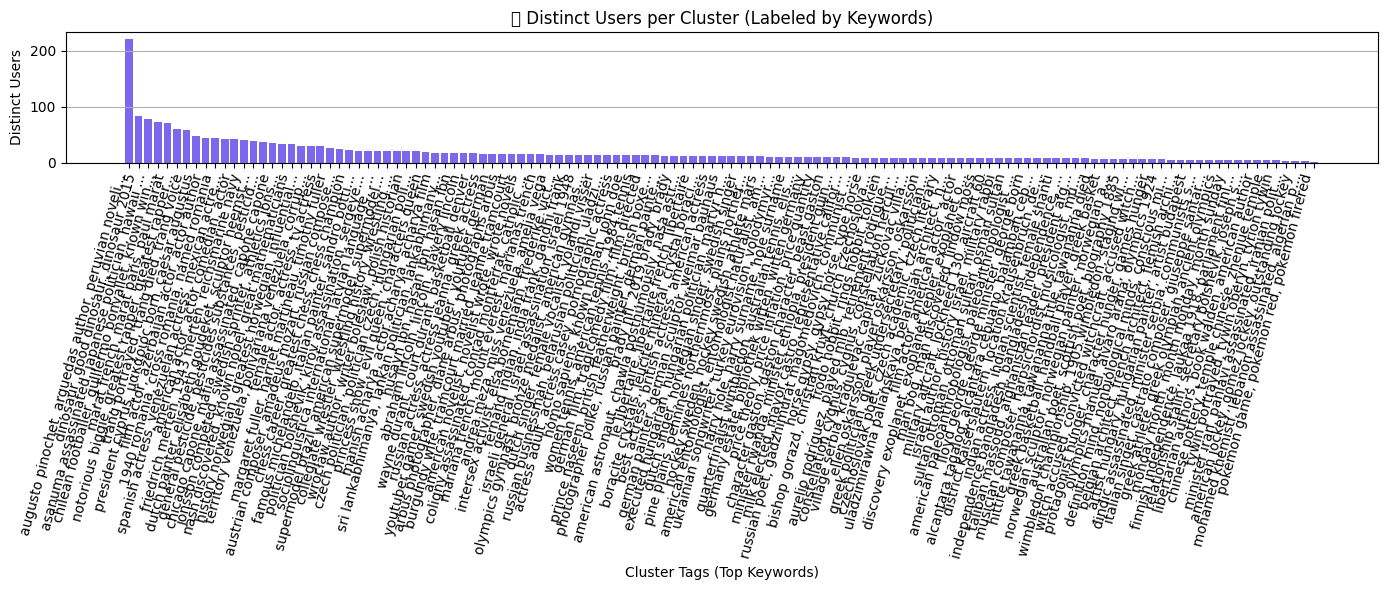

In [ ]:
import matplotlib.pyplot as plt

# Ensure user_counts_sorted and cluster_tags are defined
# Map cluster_id → tag string
user_counts_sorted['tag'] = user_counts_sorted['cluster_id'].map(lambda cid: ', '.join(cluster_tags.get(cid, [f"Cluster {cid}"])))

# Optional: shorten long tag labels
user_counts_sorted['tag_short'] = user_counts_sorted['tag'].apply(lambda t: t[:50] + "..." if len(t) > 50 else t)

# Plot
plt.figure(figsize=(14, 6))
plt.bar(user_counts_sorted['tag_short'], user_counts_sorted['distinct_user_count'], color='mediumslateblue')
plt.xticks(rotation=75, ha='right')
plt.xlabel("Cluster Tags (Top Keywords)")
plt.ylabel("Distinct Users")
plt.title("📊 Distinct Users per Cluster (Labeled by Keywords)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tqdm import tqdm

# ------------------------------
# Input: embedding_matrix (QID x 768)
# ------------------------------

# Configurations
cluster_counts = [60, 65, 70, 75]  # New range
reducers = {
    "PCA": PCA(n_components=50, random_state=42),
    "UMAP": umap.UMAP(n_components=50, random_state=42),
}
clustering_algos = {
    "KMeans": lambda k: KMeans(n_clusters=k, random_state=42),
    "GMM": lambda k: GaussianMixture(n_components=k, random_state=42),
    "Spectral": lambda k: SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors'),
}

results = []

print("🚀 Starting clustering experiment with higher cluster counts...")

# Loop through reduction methods
for reducer_name, reducer in reducers.items():
    print(f"\n🔄 Reducing dimensions with {reducer_name}...")
    X_reduced = reducer.fit_transform(embedding_matrix)

    for algo_name, algo_fn in clustering_algos.items():
        for k in cluster_counts:
            print(f"🤖 Clustering with {algo_name} (k={k})...")
            try:
                model = algo_fn(k)
                if algo_name == "GMM":
                    labels = model.fit_predict(X_reduced)
                else:
                    labels = model.fit(X_reduced).labels_

                sil = silhouette_score(X_reduced, labels)
                ch = calinski_harabasz_score(X_reduced, labels)
                db = davies_bouldin_score(X_reduced, labels)

                results.append({
                    "Reducer": reducer_name,
                    "Clustering": algo_name,
                    "Clusters": k,
                    "Silhouette": sil,
                    "Calinski-Harabasz": ch,
                    "Davies-Bouldin": db
                })
            except Exception as e:
                print(f"❌ Failed: {algo_name} with {k} clusters — {e}")

# Create results DataFrame and rank
df_results = pd.DataFrame(results)
df_results["Rank"] = df_results["Silhouette"].rank(ascending=False)

# Display top-ranked methods
df_results.sort_values("Silhouette", ascending=False, inplace=True)
print("\n✅ Top clustering configurations by Silhouette score:")
print(df_results.head(10))

# Optional: Save
# df_results.to_csv("clustering_high_k_results.csv", index=False)


🚀 Starting clustering experiment with higher cluster counts...

🔄 Reducing dimensions with PCA...
🤖 Clustering with KMeans (k=60)...
🤖 Clustering with KMeans (k=65)...
🤖 Clustering with KMeans (k=70)...
🤖 Clustering with KMeans (k=75)...
🤖 Clustering with GMM (k=60)...
🤖 Clustering with GMM (k=65)...
🤖 Clustering with GMM (k=70)...
🤖 Clustering with GMM (k=75)...
🤖 Clustering with Spectral (k=60)...
🤖 Clustering with Spectral (k=65)...
🤖 Clustering with Spectral (k=70)...
🤖 Clustering with Spectral (k=75)...

🔄 Reducing dimensions with UMAP...


/home/guimaraes/Desktop/wikidata_text_generate/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


🤖 Clustering with KMeans (k=60)...
🤖 Clustering with KMeans (k=65)...
🤖 Clustering with KMeans (k=70)...
🤖 Clustering with KMeans (k=75)...
🤖 Clustering with GMM (k=60)...
🤖 Clustering with GMM (k=65)...
🤖 Clustering with GMM (k=70)...
🤖 Clustering with GMM (k=75)...
🤖 Clustering with Spectral (k=60)...


/home/guimaraes/Desktop/wikidata_text_generate/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


🤖 Clustering with Spectral (k=65)...


/home/guimaraes/Desktop/wikidata_text_generate/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


🤖 Clustering with Spectral (k=70)...


/home/guimaraes/Desktop/wikidata_text_generate/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


🤖 Clustering with Spectral (k=75)...


/home/guimaraes/Desktop/wikidata_text_generate/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



✅ Top clustering configurations by Silhouette score:
   Reducer Clustering  Clusters  Silhouette  Calinski-Harabasz  \
12    UMAP     KMeans        60    0.457688       12806.639648   
13    UMAP     KMeans        65    0.438509       13276.051758   
14    UMAP     KMeans        70    0.431235       13088.704102   
15    UMAP     KMeans        75    0.421930       12947.166016   
16    UMAP        GMM        60    0.413287       11464.818359   
17    UMAP        GMM        65    0.369849       11367.631836   
19    UMAP        GMM        75    0.356556       11107.038086   
18    UMAP        GMM        70    0.353554       11007.927734   
20    UMAP   Spectral        60    0.334783        6082.340332   
22    UMAP   Spectral        70    0.282589        5060.645996   

    Davies-Bouldin  Rank  
12        0.858438   1.0  
13        0.873967   2.0  
14        0.916899   3.0  
15        0.928704   4.0  
16        0.957095   5.0  
17        0.981811   6.0  
19        1.023124   7.0  
18 